# Team members

| Id        | Student                                 |
|-----------|-----------------------------------------|
| A01795654 | Raul Astorga Castro                     |
| A01795579 | Edson Misael Astorga Castro             |
| A01373679 | Luis Miguel Balderas González de Burgos |
| A01730466 | Sinaí Avalos Rivera                     |
| A01410682 | Carlos Miguel Arvizu Durán              |

# TC 5033
## Word Embeddings

<br>

## Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


## Install and import libraries required for the model training

### Some installation suggestions

In [96]:
# !pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchtext==0.15.2
# !pip install scipy==1.9.3
# !pip install scikit-plot
# !pip install portalocker

### Import libraries

In [97]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to< plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

## Using GPU

In [98]:
if torch.cuda.is_available():
    device = torch.device('cuda') # GPU will be used if available
elif torch.backends.mps.is_available():
    device = torch.device('mps') # GPU will be used in Apple Silicon Macs if available
else:
    device = torch.device('cpu') # CPU will be used if GPU is not available
print(device)

mps


## Get the train and the test datasets and dataloaders

### AG News Classification Dataset

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

More information: https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

### Train and Test datasets

In [99]:
# Train and Test sets are created with data of the AG_NEWS

train_dataset, test_dataset = AG_NEWS() #Loads the AG_NEWS dataset into train and test sets
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset) #Here we converts the datasets to a dict format

### Creating Tokenizer

In [100]:
# Import the basic_english tokenizer from torchtext's tokenizers module
tokeniser = get_tokenizer('basic_english')

# Define a function that yields tokens from the text in the dataset
def yield_tokens(data):
    """
    This function generates tokens for each text entry in the dataset.
    
    Parameters:
        data (iterable): An iterable dataset where each entry is expected to 
                         contain text data as its second element.

    Yields (Returns):
        list of str: A list of tokens representing words or sub-words from each text.
    """
    for _, text in data:
        yield tokeniser(text)

### Building the vocabulary

Using the build_vocab_from_iterator function, which creates a vocabulary from an iterable of token lists.

This function is commonly used to build a vocabulary from the tokens in the training dataset.

In [101]:
# Build the vocabulary using tokens from the training dataset
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])

# Set the default index to the "<unk>" token, handling any out-of-vocabulary words
# encountered during model training or testing by mapping them to this token.
vocab.set_default_index(vocab["<unk>"])

### Testing the Tokenizer

In [102]:
# Tokenize a sample sentence
tokens = tokeniser('Welcome to TE3007')

# Print the tokens generated by the tokenizer and their corresponding indices in the vocabulary
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


### Calculate the number of samples to use for training and validation

In [103]:
# Determine the number of training samples, setting it to 90% of the total dataset size
NUM_TRAIN = int(len(train_dataset)*0.9)

# Determine the number of validation samples, which is the remainder (10% of the total dataset)
NUM_VAL = len(train_dataset) - NUM_TRAIN

### Split the dataset into training and validation datasets

In [104]:
# Use random_split to partition the train_dataset into two subsets:
# - train_dataset: containing NUM_TRAIN samples (90% of the original data)
# - val_dataset: containing NUM_VAL samples (10% of the original data)
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [105]:
 #Prints the lengths of the training, validation, and test datasets
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [106]:
# Function to process a batch of data before passing it to the model
def collate_batch(batch):
    """
    This function is used to preprocess each batch of data within the DataLoader.
    It handles tokenization, padding, and label adjustment for efficient model training.

    Parameters:
        batch (list of tuples): Each element is a tuple containing a label and a text string.
        max_tokens (integer): Max length on sequences

    Returns:
        torch.Tensor: Tensor of tokenized and padded text sequences.
        torch.Tensor: Tensor of processed labels, adjusted to range from 0 to 3.
    """
    # Separate labels and text sequences from the batch
    y, x = list(zip(*batch)) #
     
    # Tokenize each text entry in the batch and convert tokens to indices using the vocabulary
    x = [vocab(tokeniser(text)) for text in x]

    # Pad or truncate each tokenized sequence to a fixed length (max_tokens)
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Convert the list of token sequences and labels to PyTorch tensors
    # Adjust labels by subtracting 1 to shift their range from [1,4] to [0,3]
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

### Parameters for model training

In [107]:
# List of class labels for the AG_NEWS dataset categories
labels =  ["World", "Sports", "Business", "Sci/Tech"]

# Set the maximum sequence length for padding/truncation of text data
max_tokens = 50 # Sequences longer than this will be truncated; shorter sequences will be padded

# Set the batch size for the DataLoader
BATCH_SIZE = 256  # Number of samples processed together in each iteration

In [108]:
# Initialize DataLoaders for training, validation, and testing datasets
# Each DataLoader will use the collate_batch function to process batches of data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True) #
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

## Building the RNN model

### Set model parameters

In [109]:
EMBEDDING_SIZE = 64  # Embedding dimension, maps each word to a 64-dimensional dense vector
NEURONS = 64  # Number of neurons in the fully connected (FC) layer
LAYERS = 2  # Number of LSTM layers stacked on top of each other
NUM_CLASSES = 4  # Number of output classes, corresponding to the labels

### RNN Model

[![](rnn.webp)](rnn.webp "Recurrent Neural Networks (RNN)")

This image illustrates the architecture of a **Recurrent Neural Network (RNN)**, a type of neural network used to process sequential data by maintaining a "memory" of previous inputs. Each unit in the RNN takes an input \( x \) at each timestep \( t \), along with a hidden state \( h \) from the previous step, to produce an output \( y \) and update its hidden state. 

The hidden state acts as a form of memory, capturing information from previous steps, making RNNs especially useful for tasks like **time series forecasting, natural language processing, and sequential data analysis**. 

In the diagram, weights \( W_{xh} \) and \( W_{hy} \) govern the transformation from input to hidden state and hidden state to output, respectively.

> Mishra, P. (2024, October 3). Understanding Recurrent neural networks (RNN) — a gateway to sequential data analysis. Medium. https://medium.com/@palashm0002/understanding-recurrent-neural-networks-rnn-a-gateway-to-sequential-data-analysis-5fd535d36f2e

In [110]:
# Define the RNN model class
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        """
        Initialize the RNN model components: embedding layer, LSTM, and fully connected (FC) layer.

        Parameters:
            embed_size (int): Size of each word embedding vector.
            hidden (int): Number of neurons in the hidden layer of the LSTM.
            layers (int): Number of LSTM layers to stack.
            num_classes (int): Number of output classes for classification.
        """
        super().__init__()
        # Embedding layer that converts input word indices into dense vectors
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size) # vocab size is the total vocabulary size, embed_size is the embedding dimension
        
        # LSTM layer processes the embeddings, with batch_first=True to indicate batch size is the first tensor dimension
        self.rnn = nn.LSTM(embed_size, hidden, layers, batch_first=True)
       
        # Fully connected layer for output, maps from hidden dimension to number of classes
        self.fc = nn.Linear(hidden, num_classes)
        
    
    def forward(self, x):
        """
        Forward pass through the RNN model.

        Parameters:
            x (Tensor): Batch of input data as lists of word indices.

        Returns:
            Tensor: Logits for each class in the batch.
        """
        # Apply embedding layer to convert word indices to embedding vectors
        x = self.embedding_layer(x)
        # Pass embeddings through the LSTM, capturing the hidden state from the final LSTM cell
        output, (h,c) = self.rnn(x)        
        
        # Extract the final hidden state (last layer's hidden state from the last time step)
        x = output[:,-1,:]

        # Pass the final hidden state through the fully connected layer to get class predictions
        x = self.fc(x)
        
        return x
        

### Accuracy Function

In [111]:
def accuracy(model, loader):
    """
    Calculate the accuracy of the model on a given dataset.

    Parameters:
        model (nn.Module): The trained model to evaluate.
        loader (DataLoader): DataLoader for the dataset to evaluate.

    Returns:
        float: Accuracy of the model on the dataset as a percentage.
    """
    corrects = 0 # Counter for the correct predictions
    total = 0 # Counter for the total number of samples
    model.eval() # Set the model to evaluation mode, turning off dropout and gradient computation
    model = model.to(device=device) # Move the model to the specified device (e.g., GPU)

    with torch.no_grad():  # Disable gradient tracking to save memory and computation
        for x_batch, y_batch in loader: 
            # Move batched data to the specified device with appropriate data types
            x_batch, y_batch = x_batch.to(device=device, dtype=torch.int),y_batch.to(device=device, dtype=torch.long)

            # Pass the batch through the model to get predictions
            results = model(x_batch)
            
            # Get the predicted class for each sample (index of the max logit value)
            _, predictions = results.max(dim=1) 

             # Compare predictions to true labels and count correct predictions
            corrects += (predictions == y_batch).sum()  
            total += predictions.size(0) # Total number of samples in this batch

    # Calculate accuracy as a percentage
    accuracy = 100 * corrects / total
    
    return accuracy

### Train Function

In [112]:
def train(model, optimiser, epochs=100):
    """
    Train the model over a specified number of epochs.

    Parameters:
        model (nn.Module): The model to train.
        optimiser (torch.optim): Optimizer for updating model weights.
        epochs (int): Number of epochs to train the model.

    Prints:
        Progress of training with loss and accuracy per epoch.
    """
    model = model.to(device=device)  # Move the model to the specified device (e.g., GPU)

    # Loop over the number of epochs
    for epoch in range(epochs):
        
        # Iterate over batches in the training DataLoader
        for i, (x_batch,y_batch) in enumerate(train_loader):
            model.train() # Set the model to training mode
            
             # Move batch data to the device for computation
            x_batch, y_batch = x_batch.to(device, dtype=torch.int), y_batch.to(device, dtype=torch.long)
    
            # Forward pass: get predictions for the batch
            results = model(x_batch)

            # Calculate the cross-entropy loss, suitable for multi-class classification
            loss = F.cross_entropy(input= results, target=y_batch) 

            # Clear previous gradients for the optimizer
            optimiser.zero_grad()

            # Backward pass: compute gradients for model parameters based on loss
            loss.backward() 

            # Update the model parameters based on computed gradients
            optimiser.step()

        # Calculate accuracy on the validation dataset after each epoch
        acc = accuracy(model, val_loader)
        
        # Print the training progress including loss and accuracy for the current epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Acc: {acc}")

## Training the model

### Model's instance and optimazer

In [113]:
# Set training parameters
epochs = 3  # Number of training epochs
lr = 0.01  # Learning rate for the optimizer


# Instantiate the RNN model with defined parameters
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)

# Set up the optimizer (Adam) with the model parameters and specified learning rate
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


### Model Architecture

In [114]:
# Display model architecture
print(rnn_model)

RNN_Model_1(
  (embedding_layer): Embedding(95811, 64)
  (rnn): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


### Training

In [115]:
# Train the model using the train function with specified optimizer and epochs
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch [1/3], Loss: 0.4117, Acc: 90.01667022705078
Epoch [2/3], Loss: 0.2385, Acc: 91.48332977294922
Epoch [3/3], Loss: 0.1422, Acc: 91.36666870117188


In [116]:
# Calculate and print the model's accuracy on the test dataset
print(f'{accuracy(rnn_model, test_loader):.4f}')

91.0263


## Analyzing results

### Sample_text Function

In [117]:
def sample_text(model, loader):
    """
    Generates and prints a sample of predictions made by the model on data from the test loader.

    This function iterates over a batch from the test data, makes predictions, and outputs the 
    original text, true label, and predicted label for each sample. The function stops 
    printing when either a <pad> token is found in the reconstructed text or when the 
    second batch is processed. 

    Args:
        model (nn.Module): The trained model used for text classification.
        loader (DataLoader): The DataLoader for the test dataset, providing batches of tokenized text.

    Returns:
        None
    """
    # Set the model to evaluation mode to disable training layers like dropout
    model.eval()

    # Initialize an empty list to store each sample's information (text, true label, prediction)
    samples=[]

    # Disables gradient calculation for efficiency as this is an evaluation
    with torch.no_grad():
        # Iterate over the batches in the test loader
        for i, (x_batch, y_batch) in enumerate(loader):
            if (i == 1): # Stop after the first batch to limit output
                break
          
            # Move the batch data to the specified device (e.g., GPU if available)
            x_batch, y_batch = x_batch.to(device=device, dtype=torch.int),y_batch.to(device=device, dtype=torch.long)

            # Get predictions from the model for the current batch
            results = model(x_batch)
            _, predictions = results.max(dim=1)  # Get the predicted labels (highest scoring class index)
    
            # Iterate over each sample in the batch to retrieve and display details
            for j in range(len(x_batch)):
                # Convert token indices back to their corresponding words for readability
                text_tokens = vocab.lookup_tokens(x_batch[j].cpu().numpy())

                # Stop processing this sample if a <pad> token is encountered, indicating padding
                if text_tokens == '<pad>':
                    break

                # Join tokens to form the original text string
                original_text = ' '.join(text_tokens)

                # Retrieve the predicted and true labels using the label names
                prediction = labels[predictions[j]]
                real = labels[y_batch[j]]

                # Store the original text, true label, and prediction for each sample
                samples.append((original_text, real, prediction))
    # Print each sample's text, true label, and predicted label for inspection
    print('=== Prediction Samples: ====')
    for text, real, prediction in samples:
        print(f"Text: {text}")
        print(f"Real label: {real}")
        print(f"Predict label: {prediction}\n")



### Printing a sample of text and predictions

In [118]:
# Call sample_text to generate and display a set of prediction samples
sample_text(rnn_model, test_loader)

=== Prediction Samples: ====
Text: chile court strips pinochet of immunity ( ap ) ap - chile ' s supreme court stripped gen . augusto pinochet of immunity from prosecution thursday in a ruling that revived hopes of his foes that he might stand trial on charges of human rights abuses during his rule .
Real label: World
Predict label: World

Text: fallujah ' hostage slaughterhouses ' found ( ap ) ap - u . s . troops , on the verge of gaining control of the city , fought pockets of resistance in this former militant stronghold wednesday and uncovered what the iraqi commander said were hostage slaughterhouses in which foreign
Real label: World
Predict label: World

Text: peoplesoft revises third-quarter profit oracle target adds \$2 . 6 million to bottom line after tax adjustment related to ex-ceo ' s severance package . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Real label: Sci/Tech


### Plot Confusion Matrix

Calculates and visualizes the confusion matrix on the test set, showing the distribution of predictions across true labels. This allows for assessment of the model's performance for each class by displaying correct and incorrect predictions in a heatmap.

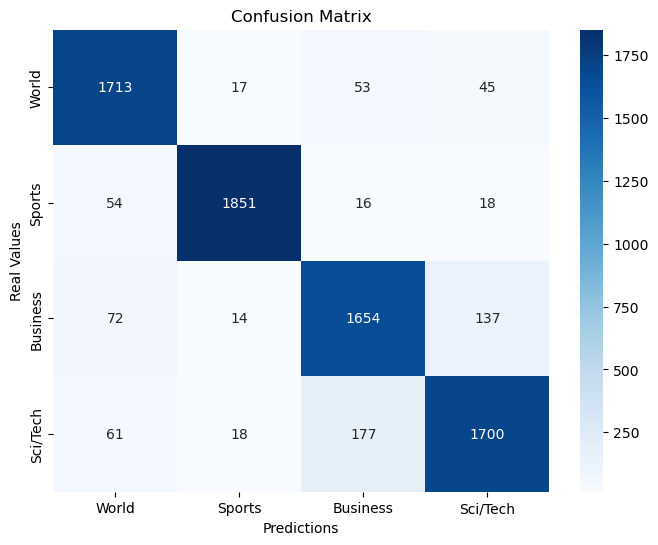

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, labels):
    """
    Computes and displays a confusion matrix using a heatmap, which shows the performance 
    of the model on each class in the test set.

    Args:
        model (nn.Module): The trained model to evaluate.
        loader (DataLoader): DataLoader for the test dataset.
        labels (list): List of class names corresponding to each label for better readability 
                       on the heatmap.

    Returns:
        None
    """
    # Set the model to evaluation mode to disable training layers like dropout
    model.eval()
    model = model.to(device) # Send model to the device (e.g., GPU if available)

    # Initialize lists to store the true and predicted labels for the entire test set
    total_predictions = []
    total_trues = []

    # Disable gradient calculation for efficiency since this is an evaluation
    with torch.no_grad():
        for x_batch, y_batch in loader:
            # Load batch data onto the device (GPU or CPU)
            x_batch, y_batch = x_batch.to(device, dtype=torch.int), y_batch.to(device, dtype=torch.long)

            # Get predictions from the model for the current batch
            results = model(x_batch)
            _, predictions = results.max(dim=1)  # Get the predicted labels (highest scoring class index)

            # Store predictions and true labels in lists for confusion matrix calculation
            total_predictions.extend(predictions.cpu().numpy())
            total_trues.extend(y_batch.cpu().numpy())

    # Calculate the confusion matrix using sklearn
    cm = confusion_matrix(total_predictions, total_trues)

    # Plot the confusion matrix using seaborn's heatmap for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Real Values')
    plt.show()

# Call the function to plot the confusion matrix for the test set predictions
plot_confusion_matrix(rnn_model, test_loader, labels)

The confusion matrix shows the model’s performance across four classes: **World**, **Sports**, **Business**, and **Sci/Tech**. Most predictions are correct, but the matrix reveals some common mistakes:

1. **Business and Sci/Tech Confusion**: The model frequently confuses **Business** with **Sci/Tech**, as shown by the 137 Sci/Tech instances incorrectly classified as Business and the 177 Business instances misclassified as Sci/Tech. This may be due to overlapping terminology or similar contexts in these fields.

2. **World vs. Sci/Tech**: A smaller, but notable, number of **World** articles are misclassified as **Sci/Tech** (45 instances). This could occur if articles on global tech issues are mistakenly interpreted as purely technical content.

3. **Business vs. World**: Some **Business** articles are confused with **World** topics (72 instances), likely when articles discuss international economic events or policies.

The matrix highlights that the model generally performs well but struggles with semantic overlaps between categories like Business and Sci/Tech, where content may not be distinctly separate.